In [1]:
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

## Load and Preprocess Data
Really just load and interpolate the current onto the same s.Sequential

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

# data = random.choices(data, k=960)

data = [{"s": sample["s"],
         "current": sample["I"],
         "frequencies": sample["freq"],
         "formfactor": sample["formfactor"]} for sample in data]

In [3]:
len(data)

79200

In [4]:
s_min = np.concatenate([sample["s"] for sample in data]).min()
s_max = np.concatenate([sample["s"] for sample in data]).max()
s_min, s_max

(-0.0007414007974541548, 0.0007591195528889543)

In [5]:
sample_indicies = [1, 42, 324]

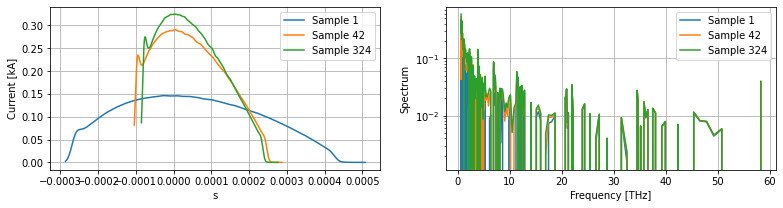

In [6]:
plt.figure(figsize=(13,3))

plt.subplot(121)
for i in sample_indicies:
    plt.plot(data[i]["s"], data[i]["current"]*1e-3, label=f"Sample {i}")
plt.xlabel("s")
plt.ylabel("Current [kA]")
plt.legend()
plt.grid()
    
plt.subplot(122)
for i in sample_indicies:
    plt.plot(data[i]["frequencies"]*1e-12, data[i]["formfactor"], label=f"Sample {i}")
plt.yscale("log")
plt.xlabel("Frequency [THz]")
plt.ylabel("Spectrum")
plt.legend()
plt.grid()

plt.show()

In [7]:
# new_s = np.linspace(-0.00075, 0.00075, 100)
new_s = np.linspace(-0.0003, 0.0003, 1000)

for i in range(len(data)):
    data[i]["current"] = np.interp(new_s, data[i]["s"], data[i]["current"], left=0, right=0)
    data[i]["s"] = new_s

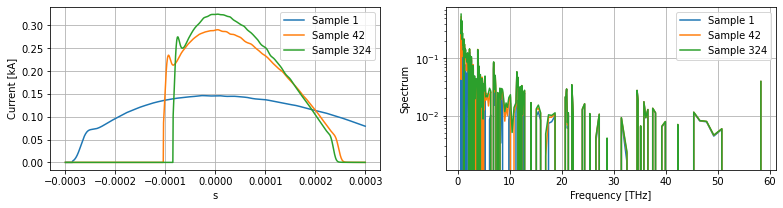

In [26]:
plt.figure(figsize=(13,3))

plt.subplot(121)
for i in sample_indicies:
    plt.plot(data[i]["s"], data[i]["current"]*1e-3, label=f"Sample {i}")
plt.xlabel("s")
plt.ylabel("Current [kA]")
plt.legend()
plt.grid()
    
plt.subplot(122)
for i in sample_indicies:
    plt.plot(data[i]["frequencies"]*1e-12, data[i]["formfactor"], label=f"Sample {i}")
plt.yscale("log")
plt.xlabel("Frequency [THz]")
plt.ylabel("Spectrum")
plt.legend()
plt.grid()

plt.show()

In [9]:
formfactors = np.stack([sample["frequencies"] for sample in data])
formfactors.shape

(79200, 240)

In [10]:
currents = np.stack([sample["current"] for sample in data])
currents.shape

(79200, 1000)

## Create Keras Model

In [11]:
epochs = 100
batch_size = 64

In [12]:
formfactor_scaler = MinMaxScaler()
scaled_formfactors = formfactor_scaler.fit_transform(formfactors)

current_scaler = MinMaxScaler()
scaled_currents = current_scaler.fit_transform(currents)

In [13]:
scaled_formfactors.min(), scaled_formfactors.max()

(0.0, 0.0)

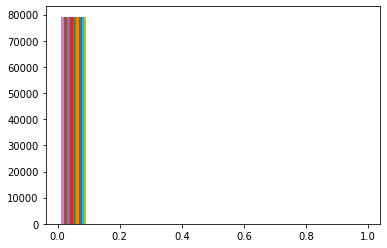

In [14]:
plt.hist(scaled_formfactors, bins=10, range=[0,1])
plt.show()

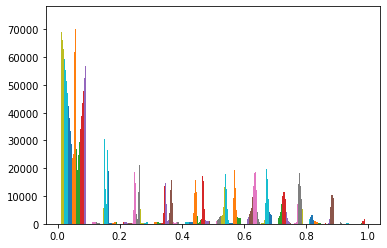

In [15]:
plt.hist(scaled_currents, bins=10, range=[0,1])
plt.show()

In [16]:
new_length = int(len(formfactors) / batch_size) * batch_size

shortened_formfactors = scaled_formfactors[:new_length]
shortened_currents = scaled_currents[:new_length]

In [17]:
model = keras.Sequential([layers.Dense(200, activation="relu"),
                          layers.Dense(100, activation="relu"),
                          layers.Dense(50, activation="relu"),
                          layers.Dense(1000)])
model.compile(optimizer="adam", loss="mse")

## Training

In [18]:
history = model.fit(shortened_formfactors, shortened_currents, epochs=100)

Epoch 1/100
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0769
Epoch 2/100
2474/2474 [==============================] - 4s 2ms/step - loss: 0.0741A: 3s - 
Epoch 3/100
2474/2474 [==============================] - 4s 2ms/step - loss: 0.0741A: 0s - loss: 0.0
Epoch 4/100
2474/2474 [==============================] - 4s 2ms/step - loss: 0.0741
Epoch 5/100
2474/2474 [==============================] - 5s 2ms/step - loss: 0.0741
Epoch 6/100
2474/2474 [==============================] - 5s 2ms/step - loss: 0.0741
Epoch 7/100
2474/2474 [==============================] - 4s 2ms/step - loss: 0.0741
Epoch 8/100
2474/2474 [==============================] - 5s 2ms/step - loss: 0.0741
Epoch 9/100
2474/2474 [==============================] - 5s 2ms/step - loss: 0.0741
Epoch 10/100
2474/2474 [==============================] - 4s 2ms/step - loss: 0.0741
Epoch 11/100
2474/2474 [==============================] - 5s 2ms/step - loss: 0.0741
Epoch 12/100
2474/2474 [=========================

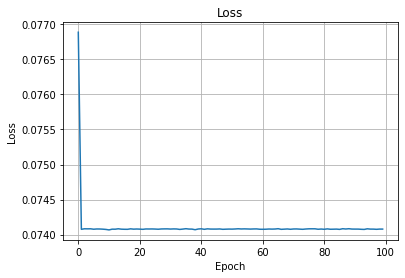

In [22]:
plt.title("Loss")
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

## Quick Test

In [23]:
X = np.stack([data[i]["formfactor"] for i in sample_indicies])
Xs = formfactor_scaler.transform(X)

y = np.stack([data[i]["current"] for i in sample_indicies])

predictions = model.predict(Xs)
predictionsn = current_scaler.inverse_transform(predictions)

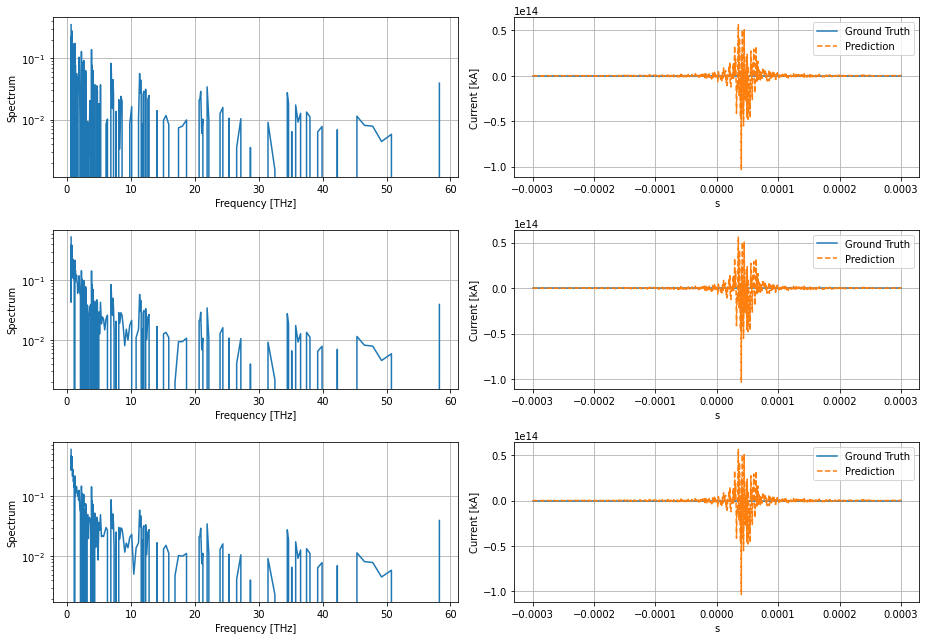

In [24]:
plt.figure(figsize=(13,9))
for i in range(len(X)):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(data[0]["frequencies"]*1e-12, X[i])
    plt.yscale("log")
    plt.xlabel("Frequency [THz]")
    plt.ylabel("Spectrum")
    plt.grid()
    
    plt.subplot(3, 2, 2*i+2)
    plt.plot(data[0]["s"], y[i]*1e-3, label="Ground Truth")
    plt.plot(data[0]["s"], predictionsn[i]*1e-3, "--", label="Prediction")
    plt.xlabel("s")
    plt.ylabel("Current [kA]")
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()